# Computer vision

## Librerías

In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim


batch_size = 4

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
partitions = ['train', 'val']

## Crear la base de datos

### Funciones para pre procesamiento 

In [2]:
train_transform = transforms.Compose(
    [transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor()])#transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

test_transform = transforms.Compose(
    [transforms.ToTensor()])#transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
train_set, val_set = torch.utils.data.random_split(trainset, [40000, 10000])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
len(trainset), len(val_set), len(testset)

(50000, 10000, 10000)

### Cargar los datos 

In [10]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=1,
                                          shuffle=True)
valLoader = torch.utils.data.DataLoader(val_set, batch_size=1,
                                          shuffle=True)
dataloaders = {'train': trainloader,\
              'val': valLoader}
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False)

In [ ]:
for data in trainloader:
    inputs, labels = data
   # print(inputs.shape)
    data_toDisplay = np.transpose(torchvision.utils.make_grid(inputs), (1, 2, 0))
   # plt.imshow(data_toDisplay)
   # plt.show()

# **Modelo UNet**

In [19]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
       # """
       # This function creates one contracting block
       # """
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                  #  torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                  #  torch.nn.BatchNorm2d(out_channels),
                )
        return block

    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
       #  """
       # This function creates one expansive block
       # """
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                   # torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                   # torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                    )
            return  block

    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
       #  """
       # This returns final block
       # """
        block = torch.nn.Sequential(
                torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                torch.nn.ReLU(),
               # torch.nn.BatchNorm2d(mid_channel),
                torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                torch.nn.ReLU(),
               # torch.nn.BatchNorm2d(mid_channel),
                torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                torch.nn.ReLU(),
               # torch.nn.BatchNorm2d(out_channels),
                )
        return  block

    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
                            torch.nn.Conv2d(kernel_size=3, in_channels=256, out_channels=512),
                            torch.nn.ReLU(),
                          #  torch.nn.BatchNorm2d(512),
                            torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=512),
                            torch.nn.ReLU(),
                          #  torch.nn.BatchNorm2d(512),
                            torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
                            )
        # Decode
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)

    def crop_and_concat(self, upsampled, bypass, crop=False):
      #  """
      #  This layer crop the layer from contraction block and concat it with expansive block vector
      #  """
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)

    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # Decode
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True)
        cat_layer2 = self.conv_decode3(decode_block3)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        cat_layer1 = self.conv_decode2(decode_block2)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=False)
        final_layer = self.final_layer(decode_block1)
        return  final_layer

In [20]:
net = UNet(in_channel= 1,out_channel=1)
#unet = unet.cuda()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.01, momentum=0.99)

# **Entrenamiento**


In [ ]:
for epoch in range(10):  # 
    for phase in partitions:
        
        if phase == partitions[0]:
            net.train()
        else:
            net.eval() 

        running_loss = 0.0
        for i, data in enumerate(dataloaders[phase]):
            # Obtener los datos
            inputs, labels = data

            
            # Inicializar los gradientes 
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == partitions[0]):
                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels.view(1,-1))
                if phase == partitions[0]: 
                    loss.backward()
                    optimizer.step()

            # print statistics
            running_loss += loss.item()
        loss_epoch =  running_loss / float(len(dataloaders[phase]))
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss_epoch))
#                 running_loss = 0.0

print('Finished Training')


RuntimeError: ignored

In [12]:
n_epochs = 8 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
   
    # train the model 
   
    net.train()
    for data, target in trainloader:
       
        #data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = net(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
    
    # validate the model 
   
    net.eval()
    for data, target in valLoader:
        
        data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = net(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(trainloader.dataset)
    valid_loss = valid_loss/len(validLoader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(net.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

RuntimeError: ignored

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## Test

## Predicción

In [ ]:


# Predicción

for data in testloader:
    inputs, labels = data
    inputs = inputs.cuda()
    labels = labels.cuda()
#     print(inputs.shape)
  #  data_toDisplay = np.transpose(torchvision.utils.make_grid(inputs.cuda()), (1, 2, 0))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(1)))
    fig = plt.figure(figsize=(2,2))
    plt.imshow(data_toDisplay)
    plt.show()
    
    outputs = net(inputs.cuda())
    _, predicted = torch.max(outputs, 1)
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(1)))




In [ ]:
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))



In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

# **Data augmentation**

In [2]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import backend as K
import numpy as np

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 20s 0us/step


In [4]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

Estandarización

In [5]:
X_train/=255
X_test/=255

Rotación de las imágenes

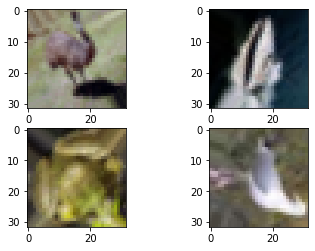

In [6]:
datagen = ImageDataGenerator(rotation_range=359)
datagen.fit(X_train)

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=4, seed=499):
  for i in range(0,4):
    pyplot.subplot(220 +1 +i)
    pyplot.imshow(X_batch[i])
  pyplot.show()
  break

Desplazamiento vertical

In [ ]:
datagen = ImageDataGenerator(height_shift_range=0.5)
datagen.fit(X_train)

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=4, seed=499):
  for i in range(0,4):
    pyplot.subplot(220 +1 +i)
    pyplot.imshow(X_batch[i])
  pyplot.show()
  break

Featurewise Center

In [ ]:
datagen = ImageDataGenerator(featurewise_center=True)
datagen.fit(X_train)

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=4, seed=499):
  for i in range(0,4):
    pyplot.subplot(220 +1 +i)
    pyplot.imshow(X_batch[i])
  pyplot.show()
  break

Samplewise Center

In [ ]:
datagen = ImageDataGenerator(samplewise_center=True)
datagen.fit(X_train)

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=4, seed=499):
  for i in range(0,4):
    pyplot.subplot(220 +1 +i)
    pyplot.imshow(X_batch[i])
  pyplot.show()
  break

Featurewise std_normalization

In [ ]:
datagen = ImageDataGenerator(featurewise_std_normalization=True)
datagen.fit(X_train)

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=4, seed=499):
  for i in range(0,4):
    pyplot.subplot(220 +1 +i)
    pyplot.imshow(X_batch[i])
  pyplot.show()
  break

Samplewise std_normalization

In [ ]:
datagen = ImageDataGenerator(samplewise_std_normalization=True)
datagen.fit(X_train)

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=4, seed=499):
  for i in range(0,4):
    pyplot.subplot(220 +1 +i)
    pyplot.imshow(X_batch[i])
  pyplot.show()
  break

Zca Whitening

In [ ]:
datagen = ImageDataGenerator(zca_whitening=True)
datagen.fit(X_train)

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=4, seed=499):
  for i in range(0,4):
    pyplot.subplot(220 +1 +i)
    pyplot.imshow(X_batch[i])
  pyplot.show()
  break

Zoom Range

In [ ]:
datagen = ImageDataGenerator(zoom_range=0.3)
datagen.fit(X_train)

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=4, seed=499):
  for i in range(0,4):
    pyplot.subplot(220 +1 +i)
    pyplot.imshow(X_batch[i])
  pyplot.show()
  break

In [10]:
import os

import scipy.io
from skimage.transform import resize
from tqdm import tqdm, trange
import gc
import torch
import sys
gc.collect()
use_gpu = torch.cuda.is_available()

def thresh(x):
    if x == 0:
        return 0
    else:
        return 1

thresh = np.vectorize(thresh, otypes=[np.float])

def create_dataset(paths, width_in, height_in, width_out, height_out, data_indexes, mat):
    x = []
    y = []
    for path in tqdm(paths):
        mat = scipy.io.loadmat(path)
        img_tensor = mat['images']
        fluid_tensor = mat['manualFluid1']
        img_array = np.transpose(img_tensor, (2, 0 ,1)) / 255
        img_array = resize(img_array, (img_array.shape[0], width_in, height_in))
        fluid_array = np.transpose(fluid_tensor, (2, 0 ,1))
        fluid_array = thresh(fluid_array)
        fluid_array  = resize(fluid_array, (fluid_array .shape[0], width_out, height_out))

        for idx in data_indexes:
            x += [np.expand_dims(img_array[idx], 0)]
            y += [np.expand_dims(fluid_array[idx], 0)]
    return np.array(x), np.array(y)

def get_dataset(width_in, height_in, width_out, height_out):
    input_path = os.path.join('2015_BOE_Chiu')
    subject_path = [os.path.join(input_path, 'Subject_0{}.mat'.format(i)) for i in range(1, 10)] + [os.path.join(input_path, 'Subject_10.mat')]
    #subject_path = [os.path.join(input_path, 'Subject_0{}.mat'.format(i)) for i in range(1, 3)]
    m = len(subject_path)
    data_indexes = [10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50]
    mat = scipy.io.loadmat(subject_path[0])
    img_tensor = mat['images']
    manual_fluid_tensor_1 = mat['manualFluid1']
    img_array = np.transpose(img_tensor, (2, 0, 1))
    manual_fluid_array = np.transpose(manual_fluid_tensor_1, (2, 0, 1))
    x_train, y_train = create_dataset(subject_path[:m-1], width_in, height_in, width_out, height_out, data_indexes, mat)
    x_val, y_val = create_dataset(subject_path[m-1:], width_in, height_in, width_out, height_out, data_indexes, mat)
    return x_train, y_train,x_val,y_val

def train_step(inputs, labels, optimizer, criterion, unet, width_out, height_out):
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = unet(inputs)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows)
    outputs = outputs.permute(0, 2, 3, 1)
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes)
    m = outputs.shape[0]
    outputs = outputs.resize(m*width_out*height_out, 2)
    labels = labels.resize(m*width_out*height_out)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss

def get_val_loss(x_val, y_val, width_out, height_out, unet):
    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).long()
    if use_gpu:
        x_val = x_val.cuda()
        y_val = y_val.cuda()
    m = x_val.shape[0]
    outputs = unet(x_val)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows) 
    outputs = outputs.permute(0, 2, 3, 1)
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes) 
    outputs = outputs.resize(m*width_out*height_out, 2)
    labels = y_val.resize(m*width_out*height_out)
    loss = F.cross_entropy(outputs, labels)
    return loss.data

def train(unet, batch_size, epochs, epoch_lapse, threshold, learning_rate, criterion, optimizer, x_train, y_train, x_val, y_val, width_out, height_out):
    epoch_iter = np.ceil(x_train.shape[0] / batch_size).astype(int)
    t = trange(epochs, leave=True)
    for _ in t:
        total_loss = 0
        for i in range(epoch_iter):
            batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size]).float()
            batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size]).long()
            if use_gpu:
                batch_train_x = batch_train_x.cuda()
                batch_train_y = batch_train_y.cuda()
            batch_loss = train_step(batch_train_x , batch_train_y, optimizer, criterion, unet, width_out, height_out)
            total_loss += batch_loss
        if (_+1) % epoch_lapse == 0:
            val_loss = get_val_loss(x_val, y_val, width_out, height_out, unet)
            print("Total loss in epoch %f : %f and validation loss : %f" %(_+1, total_loss, val_loss))
    gc.collect()

def plot_examples(unet, datax, datay, num_examples=3):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(18,4*num_examples))
    m = datax.shape[0]
    for row_num in range(num_examples):
        image_indx = np.random.randint(m)
        image_arr = unet(torch.from_numpy(datax[image_indx:image_indx+1]).float().cuda()).squeeze(0).detach().cpu().numpy()
        ax[row_num][0].imshow(np.transpose(datax[image_indx], (1,2,0))[:,:,0])
        ax[row_num][1].imshow(np.transpose(image_arr, (1,2,0))[:,:,0])
        ax[row_num][2].imshow(image_arr.argmax(0))
        ax[row_num][3].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,0])
    plt.show()


In [24]:
    width_in = 284
    height_in = 284
    width_out = 196
    height_out = 196
    PATH = './unet.pt'
    #x_train, y_train, x_val, y_val = get_dataset(width_in, height_in, width_out, height_out)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    batch_size = 3
    epochs = 1
    epoch_lapse = 50
    threshold = 0.5
    learning_rate = 0.01
    #net = UNet(in_channel=1,out_channel=2)
    if use_gpu:
        unet = unet.cuda()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr = 0.01, momentum=0.99)
    train(net, batch_size, epochs, epoch_lapse, threshold, learning_rate, criterion, optimizer, X_train, y_train, X_test, y_test, width_out, height_out)
    print(net.eval())
    plot_examples(net, X_train, y_train)
    plot_examples(net, X_test, y_test)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


  0%|          | 0/1 [00:00<?, ?it/s]


RuntimeError: ignored